# Logistic regression with sklearn. 
### Predicting sentiment from product reviews




This notebook builds on Coursera course: Machine Learning: Classification (week1)

It demonstrates **appilication of logistic regression for product sentiment prediction.**

The notebook is divided into two parts. The first part is responsible for libraries imports and containes functions used and common parameters like dataset path.The second section is the actuall flow. The diagram below shows the first part of it, which is building the logistic regression model and testing it

![Data Flow](logistic_regression_flow_a.png)

The coefficients from the model are then used to obtain the most significat words influencing classification. Several subsets of these words warying in size are used to build new logistic regresession models, which are compared on train and test sets. These allows to observe the overfitting increasing with the size of significant words subset

![Data Flow](logistic_regression_flow_b.png)


## GENERAL

### Libraries

In [1]:
import pandas as pd
import json
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import string
import math
import matplotlib.pyplot as plt

### Functions

In [2]:
def load_dataset_from_csv(path_to_dataset,data_types_ditc):
    dataset = pd.read_csv(path_to_dataset,dtype=data_types_ditc)
    return dataset

In [3]:
def remove_na(dataset,column):
    print("n/a before: " + str(dataset[column].isnull().sum()))
    dataset[column].fillna('',inplace = True)
    print("n/a before: " + str(dataset[column].isnull().sum()))

In [4]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '',string.punctuation))

In [5]:
def read_json(json_path):
    f = open(json_path)
    data = json.load(f)
    f.close()
    return data

In [6]:
def prepare_word_matrices(train_set,test_set,sample_indicies,column,pattern):
    vectorizer = CountVectorizer(token_pattern = pattern)
    # build train word matrix
    train_matrix = vectorizer.fit_transform(train_set[column])
    # build test word matrix according to train matrix
    test_matrix = vectorizer.transform(test_set[column])
    # build test for smple data
    sample_data = test_set.iloc[sample_indicies]
    sample_matrix = vectorizer.transform(sample_data[column])
    
    
    
    return train_matrix,test_matrix, sample_matrix, 

In [7]:
def prepare_word_matrix_for_sample(sample_data,column,pattern):
    vectorizer = CountVectorizer(token_pattern = pattern)
    sample_matrix = vectorizer.fit_transform(sample_data[column])
    return sample_matrix
    

In [8]:
def predict_class_and_probability(model,input_matrix):
    scores = model.decision_function(input_matrix)
    classes = [1 if i > 0 else -1 for i in scores]
    probablilities = [(1/(1 + (math.e)**(-i))) for i in scores] ## logistic function
    print('scores: ',scores)
    print('classes: ',classes)
    print('probabilities: ' ,probablilities)
    
    
    return scores,classes,probablilities

In [9]:
def predict_possiibilities_model(model,input_matrix):
    return sentiment_model.predict_proba(input_matrix)[:,1]

In [10]:
def build_coeff_df(model,pattern,train_set,column):
    vectorizer = CountVectorizer(token_pattern = pattern)
    # build train word matrix
    train_matrix = vectorizer.fit_transform(train_set[column])
    words_sentiment_model = vectorizer.get_feature_names_out()
    coefficients = model.coef_[0]
    coefficients_df = pd.DataFrame(list(zip(words_sentiment_model,coefficients)),columns=['word','coef'])
    return coefficients_df

In [11]:
def get_most_significant_words(df,number):
    return df.sort_values('coef').iloc[:number],df.sort_values('coef',ascending = False).iloc[:number]

In [12]:
def asses_model(model,train_matrix,test_matrix,train_data,test_data,column):
    predicted_train_classes = model.predict(train_matrix)
    train_accuracy = (predicted_train_classes == train_data[column]).sum()/predicted_train_classes.shape
    predicted_test_classes = model.predict(test_matrix)
    test_accuracy = (predicted_test_classes == test_data[column]).sum()/predicted_test_classes.shape
    return train_accuracy[0],test_accuracy[0]

In [13]:
dataset = 'amazon_baby.csv'

In [14]:
types_dict = {'name': str, 'review': str, 'rating': int}

In [15]:
token_pattern = r'\b\w+\b'

### Flow

### load and clean data

In [16]:
products = load_dataset_from_csv(dataset,types_dict)

In [17]:
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [18]:
remove_na(products,'review')

n/a before: 829
n/a before: 0


In [19]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [20]:
products.head()

,name,review,rating,review_clean
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,These flannel wipes are OK but in my opinion n...
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...


In [21]:
products = products[products['rating']!=3]
products.reset_index(inplace=True, drop=True)
products['sentiment'] = products['rating'].apply(lambda x : +1 if x > 3 else -1)

In [22]:
products.head()

,name,review,rating,review_clean,sentiment
0,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
1,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
2,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
3,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
4,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1


In [23]:
products['sentiment'].value_counts()

 1    140259
-1     26493
Name: sentiment, dtype: int64

### split into train and test sets

In [24]:
train_indicies = read_json('module-2-assignment-train-idx.json')
test_indicies = read_json('module-2-assignment-test-idx.json')

In [25]:
train_data = products.iloc[train_indicies]

In [26]:
test_data = products.iloc[test_indicies]

### build the word count vector (bag-of-word features) for each review in products

In [27]:
vectorizer = CountVectorizer(token_pattern=token_pattern)

In [28]:
train_matrix = vectorizer.fit_transform(train_data['review_clean'])

In [29]:
test_matrix = vectorizer.transform(test_data['review_clean'])

In [30]:
sample_rows = [10,11,12]

In [31]:
sample_matrix = vectorizer.transform(test_data.iloc[sample_rows]['review_clean'])

### train a sentiment classifier 

In [32]:
sentiment_model = LogisticRegression(solver='liblinear') 
sentiment_model.fit(train_matrix,train_data['sentiment'])

LogisticRegression(solver='liblinear')

### predict classes and probabilities using custom function


In [33]:
predict_class_and_probability(sentiment_model,sample_matrix)

scores:  [  5.60155097  -3.16959675 -10.42376824]
classes:  [1, -1, -1]
probabilities:  [0.9963214488020146, 0.0403260183986542, 2.971680162751617e-05]


(array([  5.60155097,  -3.16959675, -10.42376824]),
 [1, -1, -1],
 [0.9963214488020146, 0.0403260183986542, 2.971680162751617e-05])

### predict probabilities using model, extract significant words

In [34]:
predict_possiibilities_model(sentiment_model,sample_matrix)

array([9.96321449e-01, 4.03260184e-02, 2.97168016e-05])

In [35]:
coefficients = build_coeff_df(sentiment_model,token_pattern,train_data,'review_clean')

In [36]:
neg_words, pos_words = get_most_significant_words(coefficients,20)

### Test model

In [37]:
asses_model(sentiment_model,train_matrix,test_matrix,train_data,test_data,'sentiment')

(0.9684895364873778, 0.9322954163666907)

### Build models from most significant words

In [38]:
significant_words = neg_words['word'].to_list() + pos_words['word'].to_list()

In [39]:
print(significant_words[-20:])

['pleasantly', 'amazed', 'ply', 'excellent', 'downside', 'saves', 'perfect', 'rich', 'outstanding', 'girly', 'lifesaver', 'con', 'delivers', 'highly', 'glad', 'complaints', 'minor', 'penny', 'perfectly', 'awesome']


In [40]:
print(significant_words[:20])

['dissapointed', 'worthless', 'pointless', 'worst', 'theory', 'disappointing', 'useless', 'poorly', 'concept', 'poor', 'unusable', 'ineffective', 'disappointed', 'returned', 'frustrating', 'nope', 'returning', 'terrible', 'waste', 'tomorrow']


In [41]:
vectorizer_word_subset = CountVectorizer(vocabulary=significant_words) 
train_matrix_word_subset = vectorizer_word_subset.fit_transform(train_data['review_clean'])
test_matrix_word_subset = vectorizer_word_subset.transform(test_data['review_clean'])

In [42]:
simple_model = LogisticRegression(solver='liblinear')
simple_model.fit(train_matrix_word_subset,train_data['sentiment'])

LogisticRegression(solver='liblinear')

In [43]:
asses_model(simple_model,train_matrix_word_subset,test_matrix_word_subset,train_data,test_data,'sentiment')

(0.874542783474246, 0.8760499160067194)

## compare models built from subsets vocabulary

In [44]:
train_accuracies = []
test_accuracies = []
for words_number in [10,20,50,100,500,1000,2000,5000,10000,15000]:
    neg_words, pos_words = get_most_significant_words(coefficients,words_number)
    significant_words = neg_words['word'].to_list() + pos_words['word'].to_list()
    vectorizer_word_subset = CountVectorizer(vocabulary=significant_words) 
    train_matrix_word_subset = vectorizer_word_subset.fit_transform(train_data['review_clean'])
    test_matrix_word_subset = vectorizer_word_subset.transform(test_data['review_clean'])
    simple_model = LogisticRegression(solver='liblinear')
    simple_model.fit(train_matrix_word_subset,train_data['sentiment'])
    train,test = asses_model(simple_model,train_matrix_word_subset,test_matrix_word_subset,train_data,test_data,'sentiment')
    train_accuracies.append(train)
    test_accuracies.append(test)  

In [45]:
train_errors = [1 - i for i in train_accuracies]

In [46]:
test_errors = [1 - i for i in test_accuracies]

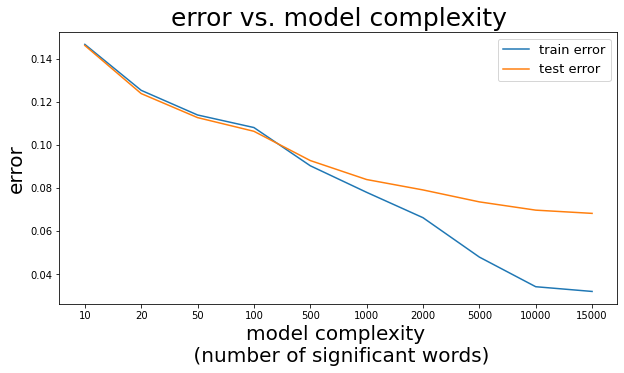

In [62]:
x_labels = ['10','20','50','100','500','1000','2000','5000','10000','15000']
fig,ax = plt.subplots(1,1,figsize = (10,5))

ax.set_title('error vs. model complexity',fontsize=25)
ax.plot(train_errors)
ax.plot(test_errors)
ax.legend(['train error','test error'],fontsize = 13)
ax.set_xticks(range(10),labels = x_labels);
ax.set_xlabel('model complexity \n (number of significant words)',fontsize = 20);
ax.set_ylabel('error',fontsize = 20);